# 2nd Assignment
## Exercise 1
2023/5/27

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import random

In [ ]:
np.random.seed(42)

## **Methods**

In [ ]:
def plot_current(dataframe):
    fig = plt.figure(figsize=(8,5))
    plt.plot(dataframe.iloc[:,0],dataframe.iloc[:,1])
    plt.xlabel("time (mS)")
    plt.ylabel("current (pA)")
    plt.grid()
    plt.title("current diagram")
    plt.show()

In [ ]:
def raster_plot(population,index):
    figure = plt.figure(figsize=(8,6))
    x,y = population.raster_plot_data(index)
    ax1 = figure.add_subplot(111)
    ax1.scatter(x,y,marker='s',s=4)
    ax1.set_ylabel("neuron ID")
    ax1.set_xlabel("time (mS)")
    ax1.set_title('raster plot',fontsize=16)

    plt.show()

In [ ]:
def plot_model(population, current):
    time = 0.03125
    dt = 0.03125
    population_spikes = []
    inner_connection_weight = 500
    inner_current = np.zeros_like(current)
    for i in range(3200):
        inner_current , spikes = population.forward(current[i] + inner_current, time, dt)
        inner_current *= inner_connection_weight
        population_spikes.append(spikes)
        time += dt

    raster_plot(population,1)

## **Import Data**

In [ ]:
const_df = pd.read_csv("/kaggle/input/currents/const_current.csv")
sine_df = pd.read_csv("/kaggle/input/currents/sine_current.csv")
steps_df = pd.read_csv("/kaggle/input/currents/steps_current.csv")

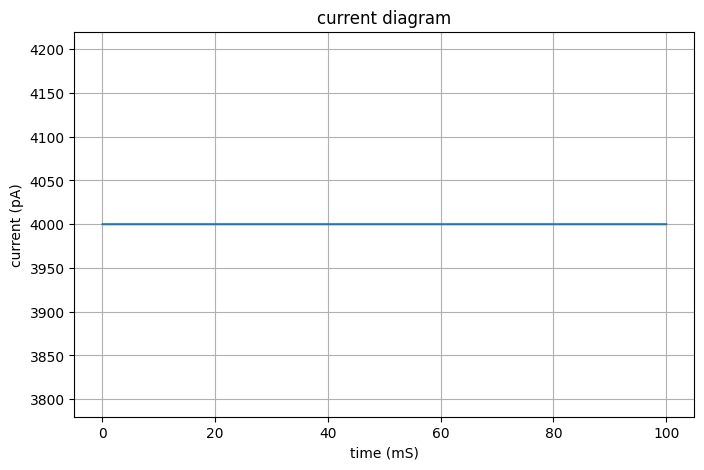

In [ ]:
plot_current(const_df)

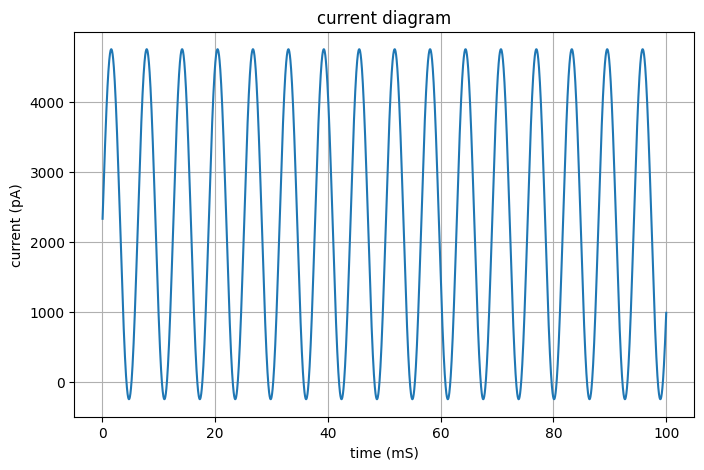

In [ ]:
plot_current(sine_df)

In [ ]:
plot_current(steps_df)

## **Define Models**

In [ ]:
class LIF:

    def __init__(self,R,tau,u_rest,threshold,u_spike,u_reset):
        self.history=[]
        self.spikes=[]
        self.current=[]
        self.R=R
        self.tau=tau
        self.u=u_rest
        self.u_rest=u_rest
        self.threshold=threshold
        self.u_spike=u_spike
        self.u_reset=u_reset


    def forward(self,input_current,time,dt):
        du=dt*(-1*(self.u-self.u_rest)+1e-3*self.R*input_current)/self.tau
        self.u+=du
        time+=dt
        self.history.append((self.u,time))
        self.current.append((input_current,time))
        if self.u>self.threshold:
                self.spikes.append(time)
                self.reset()
                return 1
        return 0

    def reset(self):
        self.u=self.u_reset

    def to_rest(self):
        self.u=self.u_rest

    def clear_history(self):
        self.history=[]
        self.spikes=[]
        self.current=[]
        self.u=self.u_rest

In [ ]:
class NeuronPopulation:

    def __init__(self,population_type,connection_details:dict,neuron_list:list):
        self.activity=[]
        self.neuron_list=neuron_list
        self.connections=np.zeros((len(neuron_list),len(neuron_list)))
        self.connection_details=connection_details
        set_connection=eval('self.'+self.connection_details['type'])
        self.population_type=population_type
        set_connection()

    def fully_connection(self):
        self.connections = np.ones_like(self.connections)*(self.connection_details['j']/len(self.neuron_list))
        self.inhibitory_coeff_mannager()

    def fully_connection_with_normal_distribution(self):
        self.connections = (np.ones_like(self.connections).reshape(-1) *
                            np.random.normal(loc=self.connection_details['j']/len(self.neuron_list),
                                              scale=1.0,
                                              size=len(self.neuron_list)**2
                                            )
                           )
        self.connections = self.connections.reshape(len(self.neuron_list), len(self.neuron_list))
        self.inhibitory_coeff_mannager()

    def random_connection_with_fixed_coupling_probablity(self):
        self.connections = np.ones_like(self.connections)*(self.connection_details['j']/len(self.neuron_list))
        self.connections = (self.connections.reshape(-1)*
                            np.random.choice([0, 1], p=[self.connection_details['p'],1-self.connection_details['p']], size=len(self.neuron_list)**2)
                           )
        self.connections = self.connections.reshape(len(self.neuron_list), len(self.neuron_list))
        self.inhibitory_coeff_mannager()

    def random_connection_with_fixed_number_of_presynaptic_partners(self):
        self.connections = np.ones_like(self.connections)*(self.connection_details['j']/len(self.neuron_list))
        zero_w = len(self.neuron_list) - int(self.connection_details['p'] * len(self.neuron_list))
        self.connections = self.connections.T
        for i in range(len(self.neuron_list)):
            zero_ind = np.random.choice(range(len(self.neuron_list)), size=zero_w)
            self.connections[i][zero_ind] = 0
        self.connections = self.connections.T


        self.inhibitory_coeff_mannager()

    def forward(self,input_current,time,dt):
        result = []
        for i,neuron in enumerate(self.neuron_list):
            result.append(neuron.forward(input_current[i],time,dt))
        self.activity.append(sum(result)/(len(neuron_list)*dt))
        activity=np.array([result]) @ self.connections.T
        return activity[0] , result

    def reset(self,reset_connection=False):
        self.activity=[]
        if reset_connection:
            set_connection=eval('self.'+self.connection_details['type'])
            set_connection()
        for neuron in self.neuron_list:
            neuron.clear_history()

    def inhibitory_coeff_mannager(self):
        if self.population_type=='inhibitory':
            self.connections=-1*self.connections


    def raster_plot_data(self,index):
        x=[]
        y=[]
        for i,neuron in enumerate(self.neuron_list):
            id=f'{index}#{i}'
            for l in neuron.spikes:
                x.append(l)
                y.append(id)
        return x,y

In [ ]:
population_size = 15
neuron_list = []
for i in range(population_size):
    neuron_list.append(LIF(10+np.random.rand()*2,8+np.random.rand()*2,-79,-50,5,-68))

## **Create full connectivity with scaling population**

In [ ]:
connection_details={
    'type':'fully_connection',
    'j':40
}
population=NeuronPopulation('exitatory',connection_details,neuron_list)

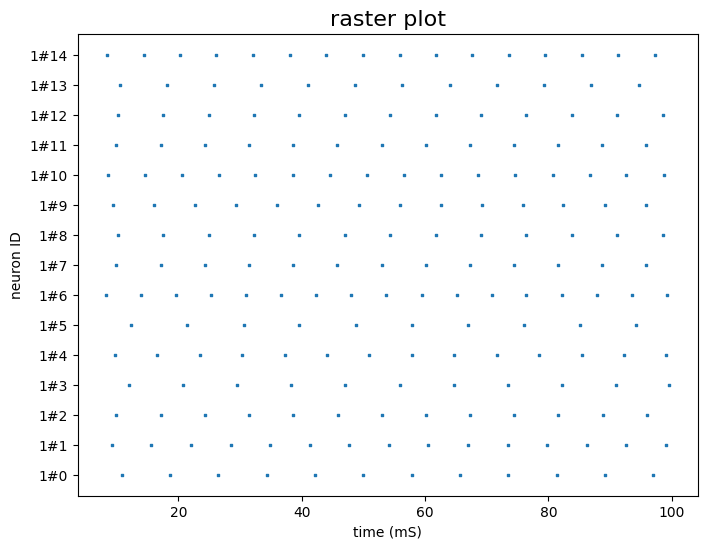

In [ ]:
current = const_df['current(pA)']
plot_model(population, current)

In [ ]:
current = sine_df['current(pA)']
plot_model(population, current)

In [ ]:
current = steps_df['current(pA)']
plot_model(population, current)

## **Create full connectivity with Normal distribution**

In [ ]:
connection_details={
    'type':'fully_connection_with_normal_distribution',
    'j':40
}
population=NeuronPopulation('exitatory',connection_details,neuron_list)

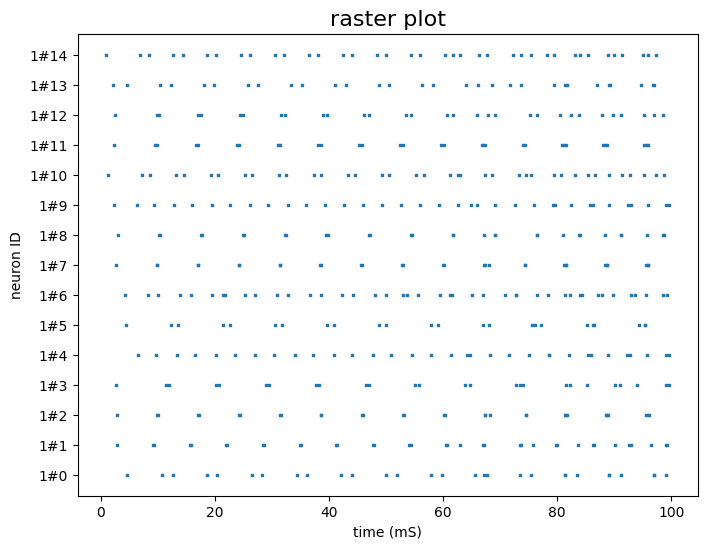

In [ ]:
current = const_df['current(pA)']
plot_model(population, current)

In [ ]:
current = sine_df['current(pA)']
plot_model(population, current)

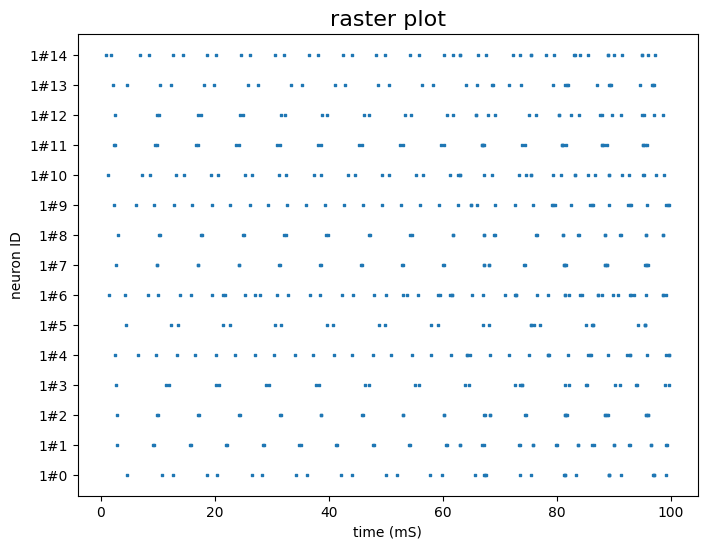

In [ ]:
current = steps_df['current(pA)']
plot_model(population, current)

## **Create random connectivity with fixed coupling probablity**

In [ ]:
connection_details={
    'type':'random_connection_with_fixed_coupling_probablity',
    'j':40,
    'p':0.1
}
population=NeuronPopulation('exitatory',connection_details,neuron_list)

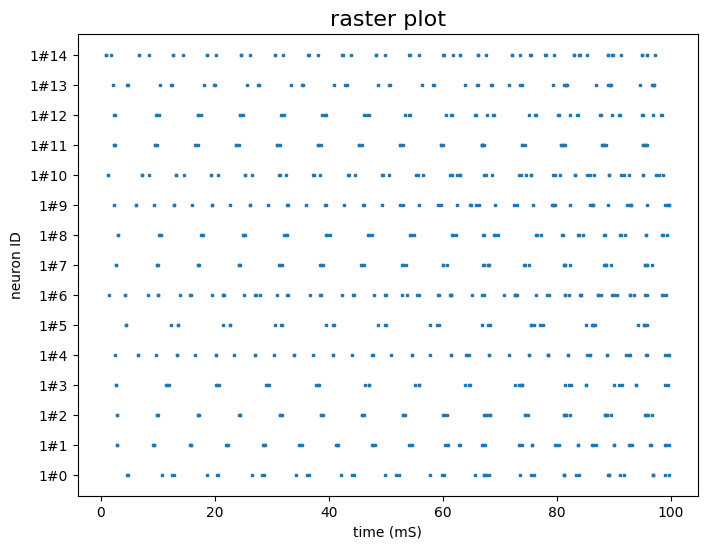

In [ ]:
current = const_df['current(pA)']
plot_model(population, current)

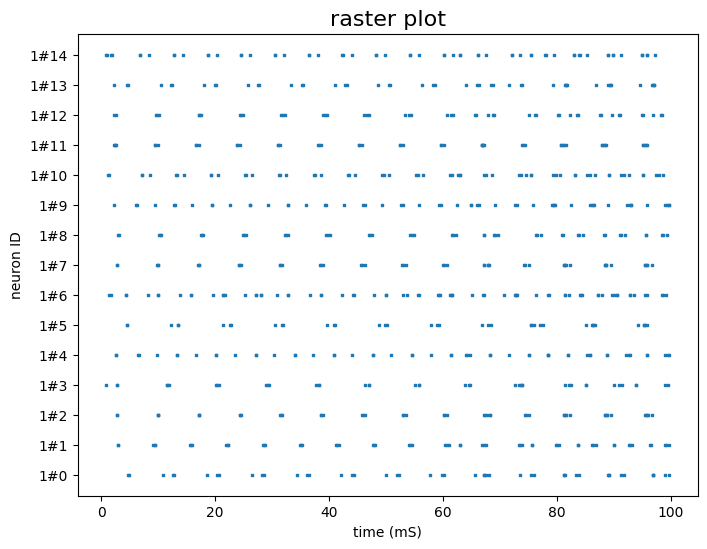

In [ ]:
current = sine_df['current(pA)']
plot_model(population, current)

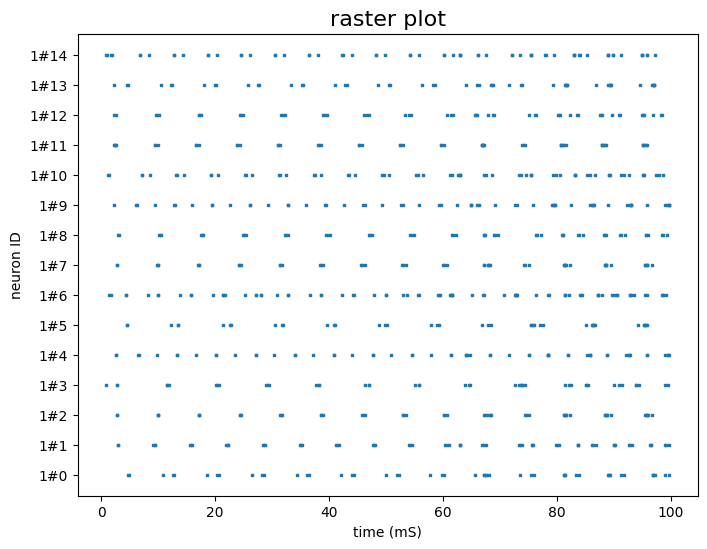

In [ ]:
current = steps_df['current(pA)']
plot_model(population, current)

## **Create random connectivity with fixed number of presynaptic partners**

In [ ]:
connection_details={
    'type':'random_connection_with_fixed_number_of_presynaptic_partners',
    'j':40,
    'p':0.9
}
population=NeuronPopulation('exitatory',connection_details,neuron_list)

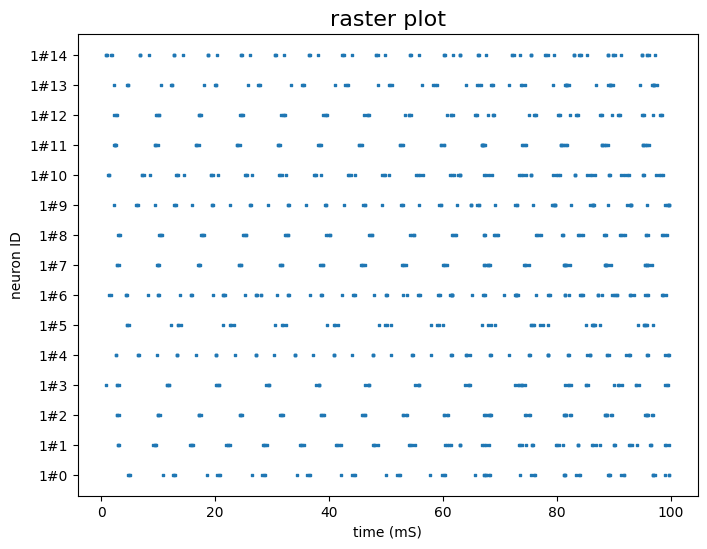

In [ ]:
current = const_df['current(pA)']
plot_model(population, current)

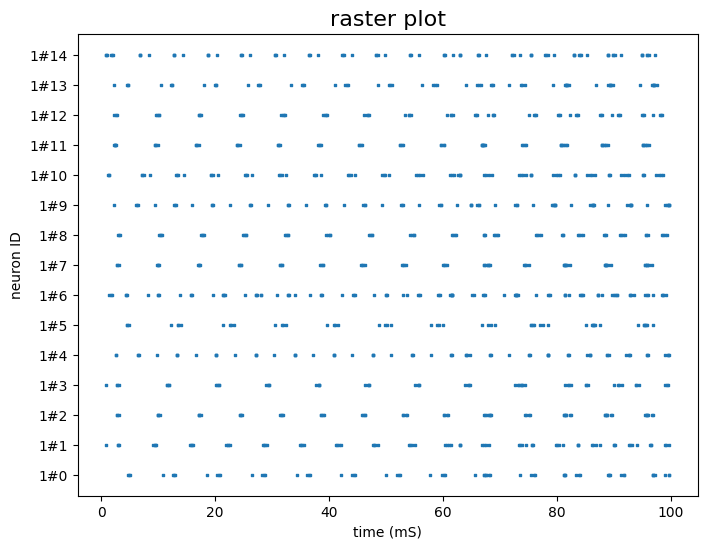

In [ ]:
current = sine_df['current(pA)']
plot_model(population, current)

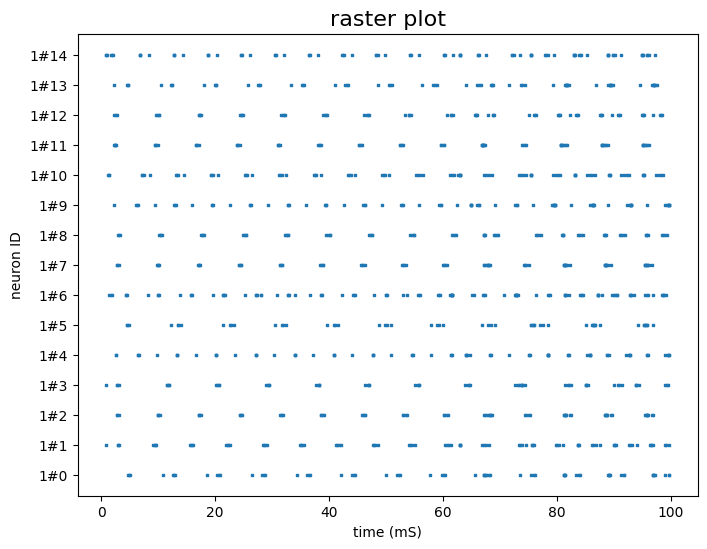

In [ ]:
current = steps_df['current(pA)']
plot_model(population, current)